In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder
from sklearn.metrics import classification_report, recall_score, confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,LabelBinarizer,MultiLabelBinarizer

### dataset tại https://www.kaggle.com/datasets/hassan06/nslkdd

In [ ]:
df_train = pd.read_csv("KDDTrain+.txt",sep = ',', encoding= 'utf-8')

In [ ]:
Columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
            'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
            'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
            'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
            'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
            'dst_host_srv_rerror_rate','attack','level'])

In [ ]:
df_train.columns = Columns

In [ ]:
df_train.shape
df_train.drop('level',axis = 1, inplace = True)

In [ ]:
df_train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal
1,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune
2,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal
3,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal
4,0,tcp,private,REJ,0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

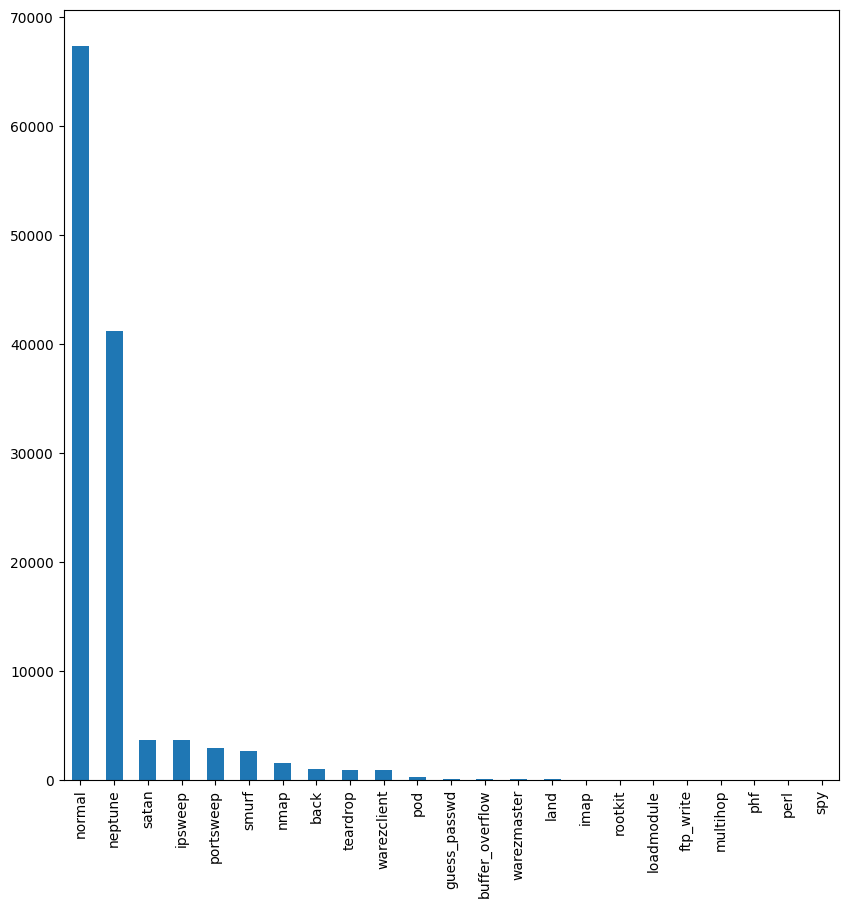

In [ ]:
plt.figure(figsize = (10,10))
explode = tuple([0.1] + [0]*(len(df_train['attack'].unique())-1))
r = df_train.attack.value_counts().plot(kind = 'bar')
r.set_xticklabels(r.get_xticklabels(),rotation=90);
plt.show()

In [ ]:
def change_label(df):
  df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [ ]:
change_label(df_train)

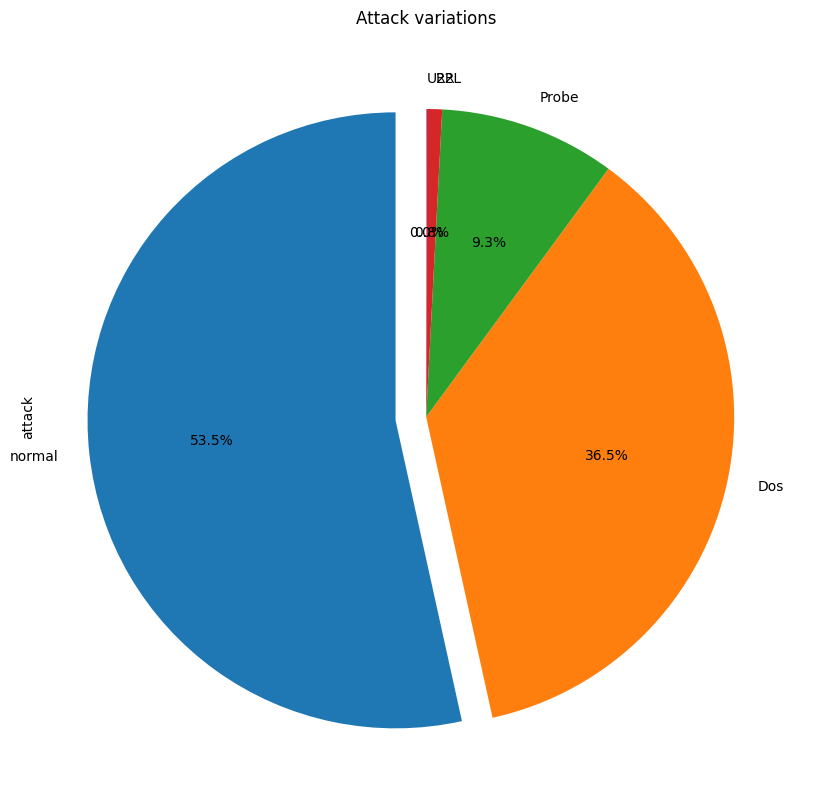

In [ ]:
plt.figure(figsize = (10,10))
explode = tuple([0.1] + [0]*(len(df_train['attack'].unique())-1)) # set the first slice to explode
df_train['attack'].value_counts().plot(kind='pie', explode=explode, startangle=90, autopct='%1.1f%%')
plt.title('Attack variations')
plt.show()

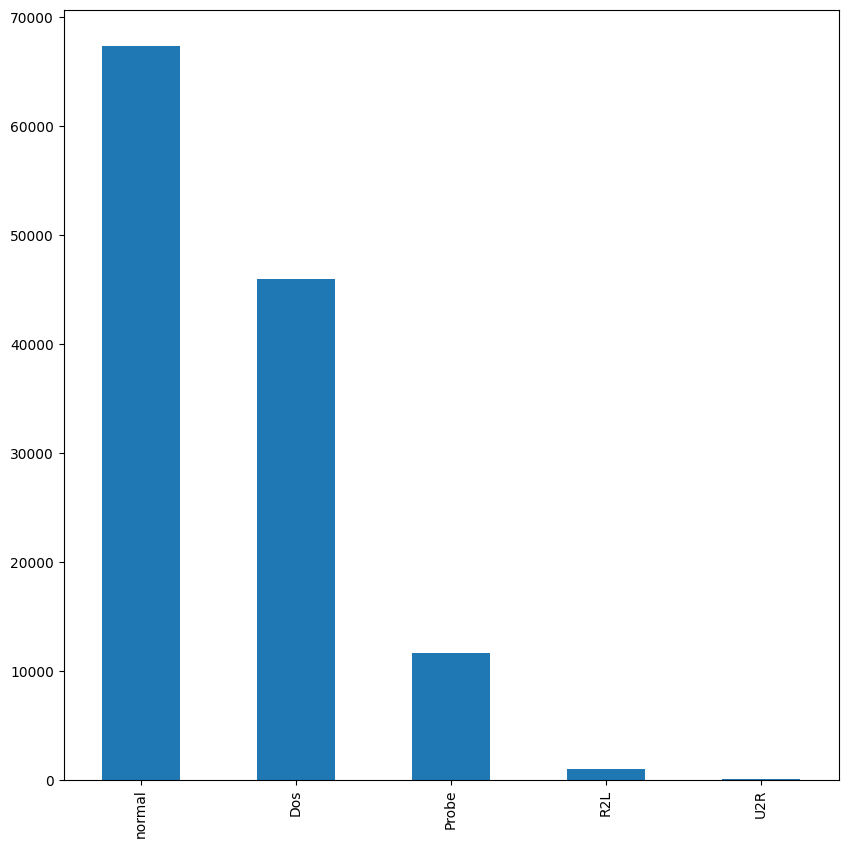

In [ ]:
plt.figure(figsize = (10,10))
explode = tuple([0.1] + [0]*(len(df_train['attack'].unique())-1))
r = df_train.attack.value_counts().plot(kind = 'bar')
r.set_xticklabels(r.get_xticklabels(),rotation=90);
plt.show()

In [ ]:
X = df_train.drop('attack',axis = 1)
y = df_train['attack']

In [ ]:
categorys =  ["protocol_type", "service", "flag","land","urgent", "logged_in", "is_host_login","is_guest_login"]
numericals = [x for x in X.columns if x not in categorys]


In [ ]:
for cat in categorys:
  X[cat] = X[cat].astype('category')

In [ ]:
X.describe()

,duration,src_bytes,dst_bytes,wrong_fragment,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,...,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.022688,0.204411,0.001222,0.279253,0.001342,0.001103,0.302194,...,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241
std,2604.525522,5.870354e+06,4.021285e+06,0.253531,2.149977,0.045239,23.942137,0.036603,0.045155,24.399715,...,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.000000,1.379964e+09,1.309937e+09,3.000000,77.000000,5.000000,7479.000000,1.000000,2.000000,7468.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Mã hoá trường dữ liệu dạng category

In [ ]:
preprocessing_categorical = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorys)
    ]
)

Mã hoá label

In [ ]:
y

0         normal
1            Dos
2         normal
3         normal
4            Dos
           ...  
125967       Dos
125968    normal
125969    normal
125970       Dos
125971    normal
Name: attack, Length: 125972, dtype: object

In [ ]:
label_encoder = LabelBinarizer()
y = label_encoder.fit_transform(y)


In [ ]:
y

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]])

In [ ]:
y = pd.DataFrame(y)
y.columns = ['Dos','Probe','U2R','R2L','normal']
y

,Dos,Probe,U2R,R2L,normal
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,0,1
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
125967,1,0,0,0,0
125968,0,0,0,0,1
125969,0,0,0,0,1
125970,1,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size= 0.8, random_state= 42)

Xây dụng tham số đánh giá

In [ ]:
def my_confusion_matrix(y_test, y_pred, plt_title, accuracy_title):
    cm=confusion_matrix(y_test, y_pred)
    print(f'{accuracy_title} Accuracy Score:', '{:.2%}'.format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='YlGnBu')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(plt_title)
    plt.show()
    return cm

Xây dựng model

In [ ]:
model = Pipeline([
    ('preprocessing', preprocessing_categorical),
    ('classifer', MultiOutputClassifier(RandomForestClassifier(n_estimators= 20,max_depth= 10, random_state= 42,class_weight='balanced')))
])

In [ ]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'urgent',
                                                   'logged_in', 'is_host_login',
                                                   'is_guest_login'])])),
                ('classifer',
                 MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=10,
                                                                        n_estimators=20,
                                                                        random_state=42)))])

In [ ]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)

Randomforest Accuracy Score: 86.24%
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      9224
           1       0.77      0.69      0.73      2373
           2       0.13      0.92      0.23       199
           3       0.01      0.46      0.02        13
           4       0.98      0.83      0.90     13386

    accuracy                           0.86     25195
   macro avg       0.56      0.77      0.56     25195
weighted avg       0.93      0.86      0.89     25195



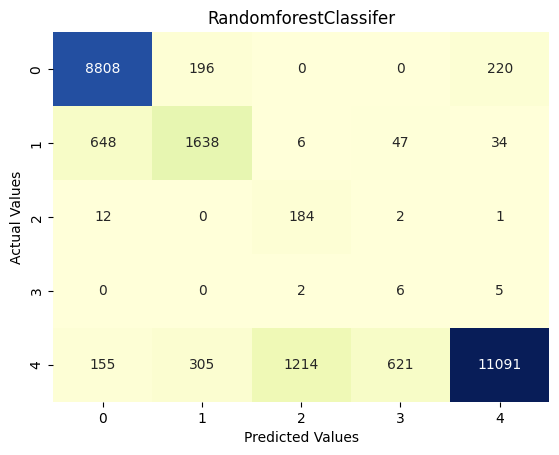

In [ ]:
cm_knn=my_confusion_matrix(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1), 'RandomforestClassifer', 'Randomforest')

Cải thiện mô hình

chuẩn hoá dữ liệu đầu vào

In [ ]:
preprocessor_numerical = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericals)
    ])

In [ ]:
full_preprocessor = ColumnTransformer(
    transformers=[
        ('preprocessor_categorical', preprocessing_categorical, categorys),
        ('preprocessor_numerical', preprocessor_numerical, numericals)
    ])

In [ ]:
model2 = Pipeline([
    ('preprocessor', full_preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators=10, max_depth=8, random_state=42)))
])

In [ ]:
model2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_categorical',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'service',
                                                                                    'flag',
                                                                                    'land',
                                                                                    'urgent',
                                                                                    'logged_in',
                                                                                    'is_host_login',
                                                                                    'is_guest_login'])]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'urgent',
                                                   'logged_in', 'is_host_login',
                                                   'is...
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_serror_rate', ...])])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=8,
                                                                        n_estimators=10,
                                                                        random_state=42)))])

In [ ]:
y_pred2 = model2.predict(X_test)

Randomforest Accuracy Score: 99.33%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9224
           1       1.00      0.96      0.98      2373
           2       0.98      0.85      0.91       199
           3       1.00      0.31      0.47        13
           4       0.99      1.00      0.99     13386

    accuracy                           0.99     25195
   macro avg       0.99      0.82      0.87     25195
weighted avg       0.99      0.99      0.99     25195



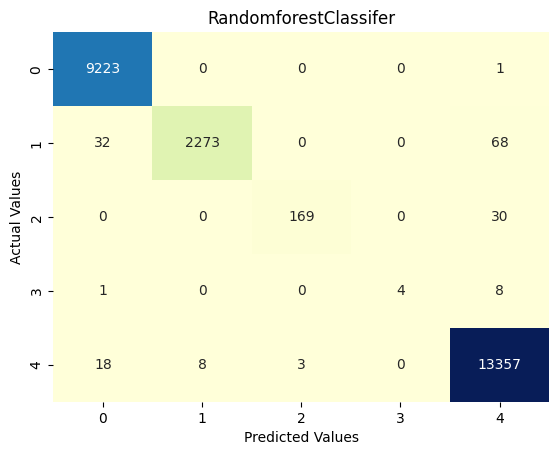

In [ ]:
cm_knn=my_confusion_matrix(y_test.values.argmax(axis = 1), y_pred2.argmax(axis = 1), 'RandomforestClassifer', 'Randomforest')

In [ ]:
model3 = Pipeline([
    ('preprocessor', full_preprocessor),
    ('classifier', MultiOutputClassifier(SVC()))
])

In [ ]:
model3.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_categorical',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'service',
                                                                                    'flag',
                                                                                    'land',
                                                                                    'urgent',
                                                                                    'logged_in',
                                                                                    'is_host_login',
                                                                                    'is_guest_login'])]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'urgent',
                                                   'logged_in', 'is_host_login',
                                                   'is...
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_serror_rate', ...])])),
                ('classifier', MultiOutputClassifier(estimator=SVC()))])

In [ ]:
y_pred3 = model3.predict(X_test)

SVM Accuracy Score: 99.14%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9224
           1       0.98      0.99      0.98      2373
           2       0.86      0.81      0.83       199
           3       1.00      0.38      0.56        13
           4       0.99      0.99      0.99     13386

    accuracy                           0.99     25195
   macro avg       0.97      0.83      0.87     25195
weighted avg       0.99      0.99      0.99     25195



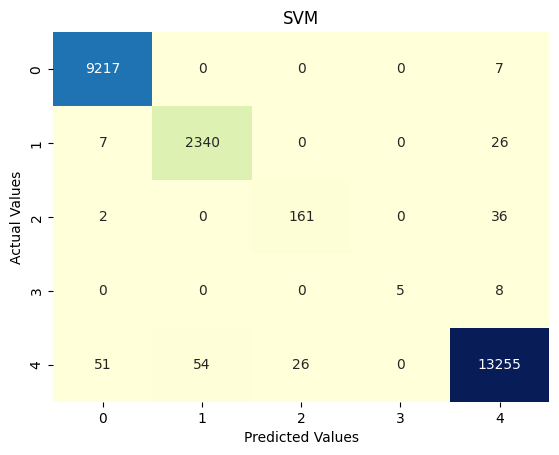

In [ ]:
cm_knn=my_confusion_matrix(y_test.values.argmax(axis = 1), y_pred3.argmax(axis = 1), 'SVM', 'SVM')

In [ ]:
preprocessing_categorical = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown= 'ignore'), categorys)
    ]
)

In [ ]:
full_preprocessor = ColumnTransformer(
    transformers=[
        ('preprocessor_categorical', preprocessing_categorical, categorys),
        ('preprocessor_numerical', preprocessor_numerical, numericals)
    ])

In [ ]:
model4 = Pipeline([
    ('preprocessor', full_preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(max_iter= 50, multi_class='multinomial')))
])

In [ ]:
model4.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_categorical',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'service',
                                                                                    'flag',
                                                                                    'land',
                                                                                    'urgent',
                                                                                    'logged_in',
                                                                                    'is_host_login',
                                                                                    'is_guest_login'])]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'urgent',
                                                   'logged_in', 'is_host_login',
                                                   'is...
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_serror_rate', ...])])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=50,
                                                                    multi_class='multinomial')))])

In [ ]:
y_pred4 = model4.predict(X_test)

LR Accuracy Score: 97.12%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9224
           1       0.95      0.95      0.95      2373
           2       0.74      0.77      0.75       199
           3       1.00      0.38      0.56        13
           4       0.98      0.97      0.98     13386

    accuracy                           0.97     25195
   macro avg       0.93      0.81      0.84     25195
weighted avg       0.97      0.97      0.97     25195



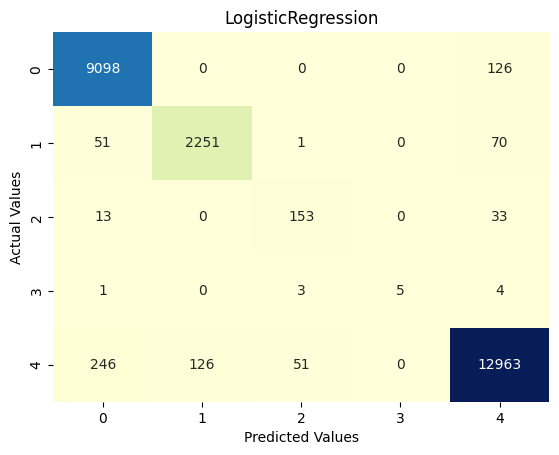

In [ ]:
cm_knn=my_confusion_matrix(y_test.values.argmax(axis = 1), y_pred4.argmax(axis = 1), 'LogisticRegression', 'LR')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model5 = Pipeline([
    ('preprocessor', full_preprocessor),
    ('classifier', MultiOutputClassifier(DecisionTreeClassifier(random_state = 42,max_features= 'sqrt', class_weight='balanced')))
])

In [ ]:
model5.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocessor_categorical',
                                                  ColumnTransformer(transformers=[('cat',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['protocol_type',
                                                                                    'service',
                                                                                    'flag',
                                                                                    'land',
                                                                                    'urgent',
                                                                                    'logged_in',
                                                                                    'is_host_login',
                                                                                    'is_guest_login'])]),
                                                  ['protocol_type', 'service',
                                                   'flag', 'land', 'urgent',
                                                   'logged_in', 'is_host_login',
                                                   'is...
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count',
                                                   'dst_host_same_srv_rate',
                                                   'dst_host_diff_srv_rate',
                                                   'dst_host_same_src_port_rate',
                                                   'dst_host_srv_diff_host_rate',
                                                   'dst_host_serror_rate', ...])])),
                ('classifier',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                        max_features='sqrt',
                                                                        random_state=42)))])

In [ ]:
y_pred5 = model5.predict(X_test)

Randomforest Accuracy Score: 99.71%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9224
           1       1.00      1.00      1.00      2373
           2       0.94      0.93      0.93       199
           3       1.00      0.62      0.76        13
           4       1.00      1.00      1.00     13386

    accuracy                           1.00     25195
   macro avg       0.99      0.91      0.94     25195
weighted avg       1.00      1.00      1.00     25195



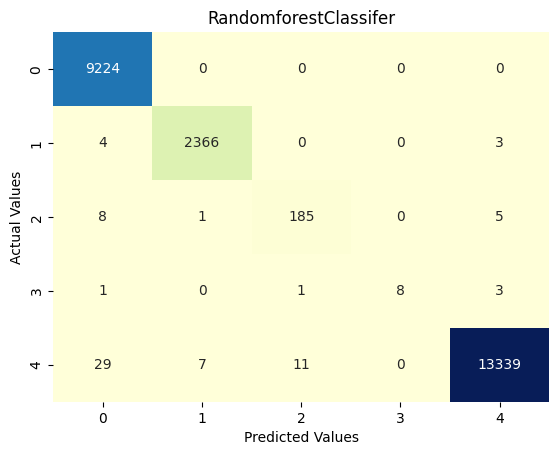

In [ ]:
cm_knn=my_confusion_matrix(y_test.values.argmax(axis = 1), y_pred5.argmax(axis = 1), 'RandomforestClassifer', 'Randomforest')

thử trên tập test

In [ ]:
testdata = pd.read_csv("KDDTest+.txt",sep=',',encoding= 'utf-8')

In [ ]:
testdata.columns = Columns

In [ ]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22543 entries, 0 to 22542
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22543 non-null  int64  
 1   protocol_type                22543 non-null  object 
 2   service                      22543 non-null  object 
 3   flag                         22543 non-null  object 
 4   src_bytes                    22543 non-null  int64  
 5   dst_bytes                    22543 non-null  int64  
 6   land                         22543 non-null  int64  
 7   wrong_fragment               22543 non-null  int64  
 8   urgent                       22543 non-null  int64  
 9   hot                          22543 non-null  int64  
 10  num_failed_logins            22543 non-null  int64  
 11  logged_in                    22543 non-null  int64  
 12  num_compromised              22543 non-null  int64  
 13  root_shell      

In [ ]:
testdata.drop('level',axis = 1,inplace = True)

In [ ]:
for cat in categorys:
  testdata[cat] = testdata[cat].astype('category')

In [ ]:
change_label(testdata)

In [ ]:
testdata_X = testdata.drop('attack',axis =1)
testdata_y = testdata["attack"]

In [ ]:
row = testdata_X.iloc[5:10,:]
row = pd.DataFrame(row)
row

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
5,0,tcp,smtp,SF,1022,387,0,0,0,0,...,255,28,0.11,0.72,0.00,0.00,0.00,0.00,0.72,0.04
6,0,tcp,telnet,SF,129,174,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.01,0.01,0.02,0.02
7,0,tcp,http,SF,327,467,0,0,0,0,...,151,255,1.00,0.00,0.01,0.03,0.00,0.00,0.00,0.00
8,0,tcp,ftp,SF,26,157,0,0,0,0,...,52,26,0.50,0.08,0.02,0.00,0.00,0.00,0.00,0.00
9,0,tcp,telnet,SF,0,0,0,0,0,0,...,255,128,0.50,0.01,0.00,0.00,0.00,0.00,0.66,0.32


In [ ]:
k = model5.predict(row)

In [ ]:
k.argmax(axis = 1)

array([4, 0, 4, 4, 4])

In [ ]:
testdata_y.iloc[5:10]

5    normal
6       R2L
7    normal
8       R2L
9     Probe
Name: attack, dtype: object

In [ ]:
k = model3.predict(row)
k.argmax(axis = 1)

array([4, 4, 4, 4, 4])

In [ ]:
yPred = model3.predict(testdata_X)


Test Accuracy Score: 74.98%
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      7459
           1       0.86      0.63      0.73      2421
           2       0.98      0.08      0.15      2885
           3       0.80      0.06      0.11        67
           4       0.66      0.97      0.78      9711

    accuracy                           0.75     22543
   macro avg       0.84      0.50      0.52     22543
weighted avg       0.81      0.75      0.71     22543



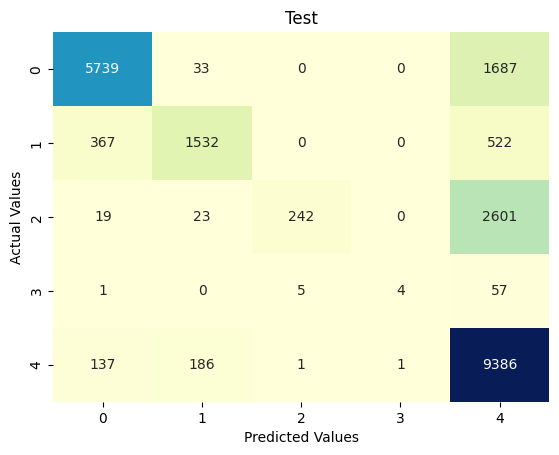

In [ ]:
testdata_y = label_encoder.transform(testdata_y)
testdata_y = pd.DataFrame(testdata_y)
cm = my_confusion_matrix(testdata_y.values.argmax(axis = 1), yPred.argmax(axis = 1),'Test','Test')